# Shift Transformation

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

In [10]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [41]:
audios = AudioList.from_folder(data_folder, use_spectro=True, cache_spectro=True, to_db_scale=True); audios

AudioList (3842 items)
AudioItem: 4.68sec (74880 @ 16000hz).,AudioItem: 3.08sec (49280 @ 16000hz).,AudioItem: 2.64sec (42240 @ 16000hz).,AudioItem: 2.56sec (40960 @ 16000hz).,AudioItem: 2.52sec (40320 @ 16000hz).
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS

160000

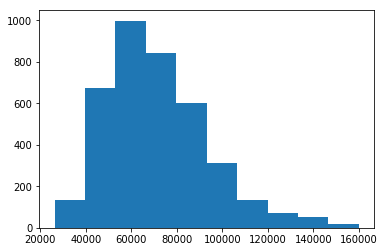

In [43]:
audio_lengths = tensor([a.ad.sig.shape[0] for a in audios])
plt.hist(audio_lengths);
audio_lengths.max().item()

In [44]:
def make_learner(data):
    newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    newlayer = newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
    ## Standard learner
    learn = cnn_learner(data, models.resnet50, metrics=accuracy)
    ## Replace the first layer in the resnet18 model with our first layer
    learn.model[0][0] = newlayer
    learn.unfreeze()
    return learn

In [45]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'
bs = 55
label_data = (audios
        .split_by_rand_pct(0.2, seed=2)
        .label_from_re(label_pattern)
 )

In [46]:
def tfms_sr(resample_rate):
    return get_audio_transforms(resample_rate=resample_rate,
                            spectro=True,
                            mx_to_pad=100000,
                            white_noise=False,
                            modulate_volume=False,
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False,
                            shift_max_pct=.6,
                            to_db_scale=True,
    )

In [30]:
tfms = tfms_sr(None)
db = label_data.transform(tfms).databunch(bs=bs)
db.train_ds[1][0].show()

NameError: name 'tfms_sr' is not defined

In [ ]:
learn = make_learner(db)
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, slice(1e-4, 4e-3))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()